In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

In [188]:
import torch # Main PyTorch Library
from torch import nn # Used for creating the layers and loss function
from torch.optim import Adam # Adam Optimizer
import torchvision.transforms as transforms # Transform function used to modify and preprocess all the images
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creating the objects
from sklearn.preprocessing import LabelEncoder # Label Encoder to encode the classes from strings to numbers
import matplotlib.pyplot as plt # Used for visualizing the images and plotting the training progress
from PIL import Image # Used to read the images from the directory
import pandas as pd # Used to read/create dataframes (csv) and process tabular data
import numpy as np # preprocessing and numerical/mathematical operations
import os # Used to read the images path from the directory

In [222]:
device = "mps" if torch.mps.is_available() else "cpu"
print("Device avaiable: ", device)

Device avaiable:  mps


Reading data paths with corresponding labels and creating DataFrame by zip function with values from image_path and labels.
Pandas for df
Zip function for zipping
os for looping through directories

In [ ]:
image_path = [] #for image paths
labels = [] #for image labes 

for i in os.listdir('./animal-faces/afhq/'): # Looping through the first directory which has the train and val images
  
    for label in os.listdir(f'./animal-faces/afhq/{i}'): # Looping through the first directory which has the labels folders
       
        for image in os.listdir(f'./animal-faces/afhq/{i}/{label}'):
           
            labels.append(label)
            image_path.append(f'./animal-faces/afhq/{i}/{label}/{image}')
            
data_df = pd.DataFrame(zip(image_path,labels), columns=['image_path','labels'])
print(data_df['labels'].unique())
data_df.tail()


['cat' 'dog' 'wild']


,image_path,labels
16125,./animal-faces/afhq/val/wild/flickr_wild_00333...,wild
16126,./animal-faces/afhq/val/wild/flickr_wild_00294...,wild
16127,./animal-faces/afhq/val/wild/flickr_wild_00083...,wild
16128,./animal-faces/afhq/val/wild/flickr_wild_00295...,wild
16129,./animal-faces/afhq/val/wild/flickr_wild_00313...,wild


Splitting dataset into training, validation and testing
70% training
15% validation
15% testing


In [191]:
train = data_df.sample(frac=0.7, random_state=7) # create training data of 70% of the data using sample() function
test = data_df.drop(train.index) #create test data by removing 70% of the train data 
val = test.sample(frac=0.5, random_state=7)
test = test.drop(val.index)

print(train.shape)
print(val.shape)
print(test.shape)

(11291, 2)
(2420, 2)
(2419, 2)


Preprocessing Objects 
LabelEndoder will convert string classes to numeric 
eg. instead of (cat, dog, wild) we will have (0,1,2)

In [192]:
data_df['labels'].unique()

array(['cat', 'dog', 'wild'], dtype=object)

In [193]:
label_encoder = LabelEncoder() # Encode the string classes to numeric
label_encoder.fit(data_df['labels'])# Fit the label encoder on our own data


transform = transforms.Compose([
    transforms.Resize((128,128)), #same size for all images
    transforms.ToTensor(),        #convert images to PyTorch tensors
    transforms.ConvertImageDtype(torch.float) #
    
    #Transform all images into one clear format (preprocess all images to same properties)
])

In [194]:
class CustomImageDataset(Dataset):
    def __init__(self,dataframe,transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(label_encoder.transform(dataframe['labels'])).to(device)
    
    def __len__(self):
        return self.dataframe.shape[0]
    
    def __getitem__(self,idx):
        img_path = self.dataframe.iloc[idx,0]
        label = self.labels[idx]
        
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image).to(device)
            
        return image, label
            
        

In [195]:
train_dataset = CustomImageDataset(dataframe= train, transform=transform)
val_dataset = CustomImageDataset(dataframe= val, transform=transform)
test_dataset = CustomImageDataset(dataframe= test, transform=transform)

In [196]:
train_dataset.__getitem__(2)

(tensor([[[0.3569, 0.6471, 0.8118,  ..., 0.1255, 0.1059, 0.0706],
          [0.3922, 0.7137, 0.8745,  ..., 0.1137, 0.0863, 0.0667],
          [0.4941, 0.7294, 0.8510,  ..., 0.1059, 0.0824, 0.0745],
          ...,
          [0.2824, 0.2588, 0.2549,  ..., 0.6941, 0.7020, 0.6902],
          [0.2471, 0.2745, 0.2431,  ..., 0.6824, 0.6941, 0.6824],
          [0.2431, 0.3059, 0.2431,  ..., 0.6627, 0.6863, 0.6745]],
 
         [[0.2706, 0.4157, 0.5569,  ..., 0.1686, 0.1490, 0.1137],
          [0.2745, 0.4863, 0.6431,  ..., 0.1529, 0.1255, 0.1059],
          [0.3333, 0.5059, 0.6431,  ..., 0.1333, 0.1059, 0.0980],
          ...,
          [0.4000, 0.3373, 0.3216,  ..., 0.7294, 0.7294, 0.7137],
          [0.3490, 0.3686, 0.3294,  ..., 0.7176, 0.7216, 0.7020],
          [0.3529, 0.4118, 0.3412,  ..., 0.7020, 0.7137, 0.6941]],
 
         [[0.1765, 0.2980, 0.4627,  ..., 0.1216, 0.1137, 0.0824],
          [0.1922, 0.3765, 0.5529,  ..., 0.1059, 0.0941, 0.0745],
          [0.2667, 0.4157, 0.5608,  ...,

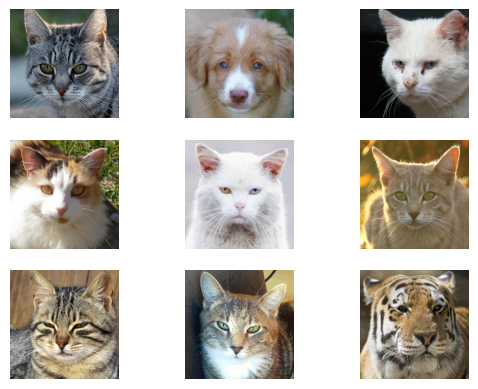

In [197]:
n_rows = 3
n_cols = 3
f, axarr = plt.subplots(n_rows,n_cols)
for row in range(n_rows):
    for col in range(n_cols):
        image = Image.open(data_df.sample(n=1)["image_path"].iloc[0]).convert('RGB')
        axarr[row,col].imshow(image)
        axarr[row,col].axis('off')
        
plt.show()
        

In [273]:
LR = 1e-3
BATCH_SIZE = 16
EPOCHS = 10

In [236]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

Building the model


In [294]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3,32,kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32,64,kernel_size=3,padding=1)
        self.conv3 = nn.Conv2d(64,128,kernel_size=3,padding=1)
        self.conv4 = nn.Conv2d(128,256,kernel_size=3,padding=1)
        
        self.pooling = nn.MaxPool2d(2,2)
        
        self.relu = nn.ReLU()
        
        self.flatten = nn.Flatten()
        
        self.linear = nn.Linear((256*8*8),256)
        
        self.output = nn.Linear(256, len(data_df['labels'].unique()))
        
    def forward(self, x):
       
        x = self.conv1(x) # -> (32,128,128)
        x = self.pooling(x) # ->(32,64,64)
        x = self.relu(x) # -> (32,64,64)
        
        x = self.conv2(x) #-> (64,64,64)
        x = self.pooling(x) # -> (64,32,32)
        x = self.relu(x)
        
        x = self.conv3(x) #-> (128,32,32) convolution layer increases the number of features but does not change the size of the image
        x = self.pooling(x) # -> (128,16,16) pooling layer doesnt change the number of features but reduces the size of the image
        x = self.relu(x)
        
        x = self.conv4(x) #-> (256,32,32) convolution layer increases the number of features but does not change the size of the image
        x = self.pooling(x) # -> (256,8,8) pooling layer doesnt change the number of features but reduces the size of the image
        x = self.relu(x)
        
        
        
        x = self.flatten(x)
        x = self.linear(x)
        x = self.output(x)
        
        return x
    
        

In [295]:
model = Net().to(device)



In [290]:
print(f"Model on: {next(model.parameters()).device}")
print(f"Data loader first batch: {next(iter(train_loader))[0].device}")

Model on: mps:0
Data loader first batch: mps:0


In [291]:
print(torch.backends.mps.is_available())  # Should be True
print(torch.backends.mps.is_built())      # Should be True

True
True


In [254]:
from torchsummary import summary
input_size = (3,128,128)

summary(model, input_size)


Input device: cpu
After conv1: cpu
After pooling: cpu
After relu: cpu
After conv2: cpu
After pooling: cpu
After relu: cpu
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 128, 128]        896
├─MaxPool2d: 1-2                         [-1, 32, 64, 64]          --
├─ReLU: 1-3                              [-1, 32, 64, 64]          --
├─Conv2d: 1-4                            [-1, 64, 64, 64]          18,496
├─MaxPool2d: 1-5                         [-1, 64, 32, 32]          --
├─ReLU: 1-6                              [-1, 64, 32, 32]          --
├─Conv2d: 1-7                            [-1, 128, 32, 32]         73,856
├─MaxPool2d: 1-8                         [-1, 128, 16, 16]         --
├─ReLU: 1-9                              [-1, 128, 16, 16]         --
├─Flatten: 1-10                          [-1, 32768]               --
├─Linear: 1-11                           [-1, 128]                 4,194,432
├─Linear: 1-12   

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 128, 128]        896
├─MaxPool2d: 1-2                         [-1, 32, 64, 64]          --
├─ReLU: 1-3                              [-1, 32, 64, 64]          --
├─Conv2d: 1-4                            [-1, 64, 64, 64]          18,496
├─MaxPool2d: 1-5                         [-1, 64, 32, 32]          --
├─ReLU: 1-6                              [-1, 64, 32, 32]          --
├─Conv2d: 1-7                            [-1, 128, 32, 32]         73,856
├─MaxPool2d: 1-8                         [-1, 128, 16, 16]         --
├─ReLU: 1-9                              [-1, 128, 16, 16]         --
├─Flatten: 1-10                          [-1, 32768]               --
├─Linear: 1-11                           [-1, 128]                 4,194,432
├─Linear: 1-12                           [-1, 3]                   387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable pa

In [296]:
criterion = nn.CrossEntropyLoss()
lr = LR
optimizer = Adam(model.parameters(),lr)
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


In [297]:

total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []


for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0
  total_loss_val = 0
  total_acc_val = 0

  for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()
    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
    total_acc_train += train_acc
    optimizer.step()

  with torch.no_grad():
    for inputs, labels in val_loader:
      outputs = model(inputs)
      val_loss = criterion(outputs, labels)
      total_loss_val += val_loss.item()

      val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
      total_acc_val += val_acc

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_validation_plot.append(round(total_loss_val/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/(train_dataset.__len__())*100, 4))
  total_acc_validation_plot.append(round(total_acc_val/(val_dataset.__len__())*100, 4))
  
  # Create a DataFrame to store the epoch-wise data
  epoch_data = pd.DataFrame({
    'Epoch': list(range(1, epoch + 2)),
    'Train Loss': total_loss_train_plot,
    'Validation Loss': total_loss_validation_plot,
    'Train Accuracy': total_acc_train_plot,
    'Validation Accuracy': total_acc_validation_plot
  })

  # Save the DataFrame to a CSV file
  epoch_data.to_csv('training_progress3.csv', index=False)

  # Print the DataFrame to verify
  print(epoch_data)
  
  print("="*25)
  
  

   Epoch  Train Loss  Validation Loss  Train Accuracy  Validation Accuracy
0      1      0.3275           0.0262         80.0726              94.0083
   Epoch  Train Loss  Validation Loss  Train Accuracy  Validation Accuracy
0      1      0.3275           0.0262         80.0726              94.0083
1      2      0.1039           0.0191         94.7215              95.6612
   Epoch  Train Loss  Validation Loss  Train Accuracy  Validation Accuracy
0      1      0.3275           0.0262         80.0726              94.0083
1      2      0.1039           0.0191         94.7215              95.6612
2      3      0.0672           0.0234         96.7851              95.1240
   Epoch  Train Loss  Validation Loss  Train Accuracy  Validation Accuracy
0      1      0.3275           0.0262         80.0726              94.0083
1      2      0.1039           0.0191         94.7215              95.6612
2      3      0.0672           0.0234         96.7851              95.1240
3      4      0.0503     

In [287]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for inputs, labels in test_loader:
    predictions = model(inputs)

    acc = (torch.argmax(predictions, axis = 1) == labels).sum().item()
    total_acc_test += acc
    test_loss = criterion(predictions, labels)
    total_loss_test += test_loss.item()

print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__()) * 100, 4)} and Loss is {round(total_loss_test/1000, 4)}")

Accuracy Score is: 96.5275 and Loss is 0.0246


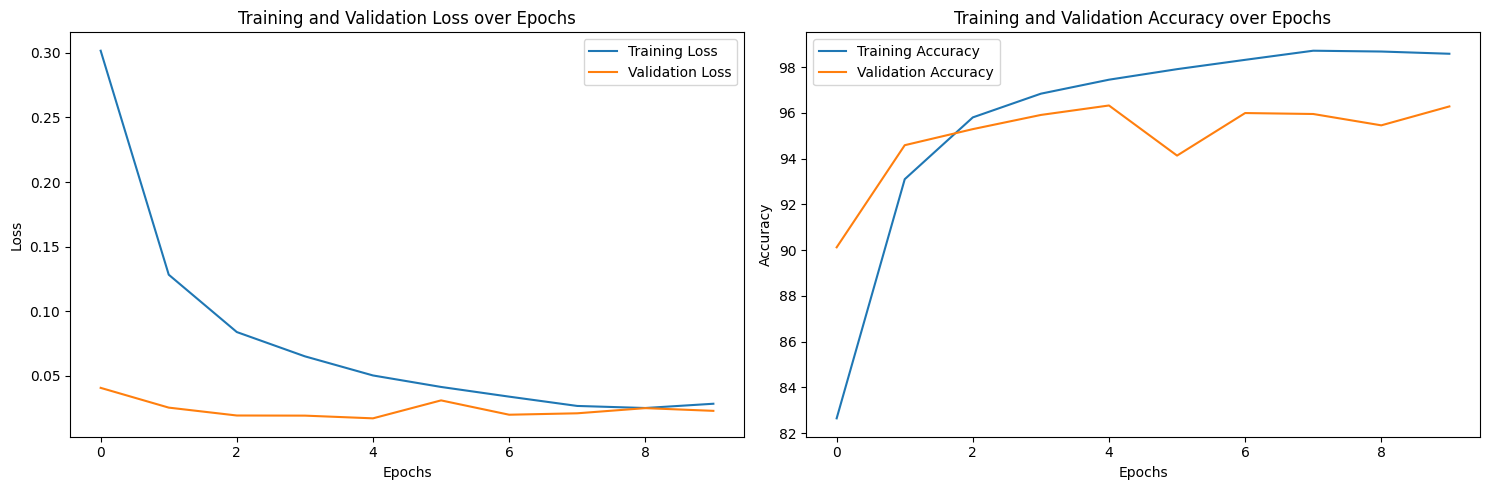

In [284]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()

plt.show()

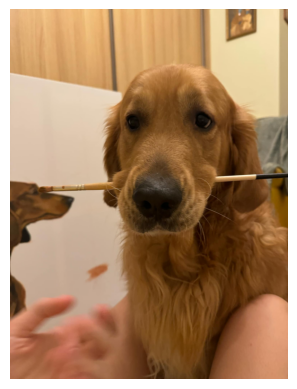


Prediction: 



array(['dog'], dtype=object)

In [286]:
# 1- read image
# 2- Transform using transform object
# 3- predict through the model
# 4- inverse transform by label encoder

def predict_image(image_path):
  image = Image.open(image_path).convert('RGB')
  image = transform(image).to(device)

  output = model(image.unsqueeze(0))
  output = torch.argmax(output, axis = 1).item()
  return label_encoder.inverse_transform([output])

## Visualize the image
image = Image.open("./falcon2.jpg")
plt.imshow(image)
plt.axis('off')
plt.show()


## Predict
print()
print("Prediction: \n")
predict_image("./falcon2.jpg")